In [5]:
import ccxt
import pandas as pd 
import numpy as np
import plotly.graph_objects as go
from datetime import datetime
import collections

//anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


# 1. Consumir datos de CCXT

In [9]:
cryptos=['BTC/USDT','BTC/USDC','ETH/USDT']
seconds=20
limite=20
exchanges=[ccxt.bitmart(),ccxt.bitforex(),ccxt.bibox()]

In [10]:
def order_book(crypto,seconds,exchanges):
    limite=20
    now=exchanges[0].milliseconds ()
    seconds=now - (seconds*1000) #20 segundos
    ob1,ob2,ob3=[],[],[]
    while seconds<now:#3600
        ob1+=collections.ChainMap(exchanges[0].fetch_order_book(crypto,limit=limite)).maps
        ob2+=collections.ChainMap(exchanges[1].fetch_order_book(crypto,limit=limite)).maps
        ob3+=collections.ChainMap(exchanges[2].fetch_order_book(crypto,limit=limite)).maps
        seconds+=1000
    return ob1,ob2,ob3

In [11]:
ob_c1=order_book(cryptos[0],seconds,exchanges)

In [5]:
ob_c2=order_book(cryptos[1],seconds,exchanges)

In [6]:
ob_c3=order_book(cryptos[2],seconds,exchanges)

In [7]:
def times(exchanges,data):
    exchange,times=[],[]
    for i in range(len(exchanges)):
        exchange.append([str(exchanges[i])]*seconds)
        for j in range(seconds):
            times.append(data[i][j]['datetime'])
    return times

In [46]:
def close_prices(exchanges,symbol,data,n):
    seconds=20
    time=times(exchanges,data)[seconds*n]
    startDate=exchanges[n].parse8601(time)
    ohlcv = exchanges[n].fetch_ohlcv(symbol, timeframe='1m', since=startDate,limit=20)
    closes = [x[4] for x in ohlcv]
    dates = [exchanges[n].iso8601 (x[0]) for x in ohlcv]
    return closes,dates

In [47]:
c1m1=close_prices(exchanges,cryptos[0],ob_c1,0)
c1m2=close_prices(exchanges,cryptos[0],ob_c1,1)
c1m3=close_prices(exchanges,cryptos[0],ob_c1,2)

c2m1=close_prices(exchanges,cryptos[1],ob_c2,0)
c2m2=close_prices(exchanges,cryptos[1],ob_c2,1)
c2m3=close_prices(exchanges,cryptos[1],ob_c2,2)

c3m1=close_prices(exchanges,cryptos[2],ob_c3,0)
c3m2=close_prices(exchanges,cryptos[2],ob_c3,1)
c3m3=close_prices(exchanges,cryptos[2],ob_c3,2)

## 1.2 Verificacion de avance

In [12]:
d={'Exchange_1':{'Crypto1':ob_c1[0],
                 'Closes':c1m1,
                 'Crypto2':ob_c2[0],
                 'Closes':c2m1,
                 'Crypto3':ob_c3[0],
                 'Closes':c3m1},
  'Exchange_2':{'Crypto1':ob_c1[1],
                 'Closes':c1m2,
                 'Crypto2':ob_c2[1],
                 'Closes':c2m2,
                 'Crypto3':ob_c3[1],
                 'Closes':c3m2},
  'Exchange_3':{'Crypto1':ob_c1[2],
                 'Closes':c1m3,
                 'Crypto2':ob_c2[2],
                 'Closes':c2m3,
                 'Crypto3':ob_c3[2],
                 'Closes':c3m3}}

# 2. Visualizacion de microestructura

## 2.2 Verificación de avance

In [13]:
def verifavance2(data,limite,seconds,exchanges):
    exchange,times=[],[]
    ask_vol,bid_vol=[],[]
    ask_voll,bid_voll=[],[]
    mid,spread=[],[]
    ask,bid=[],[]
    c=0
    df=pd.DataFrame(columns=['exchange','timeStamp','level','ask_volume','bid_volume','total_volume','mid_price','vwap'])
    for i in range(len(exchanges)):
        exchange.append([str(exchanges[i])]*seconds)
        for j in range(seconds):
            times.append(data[i][j]['datetime'])
            mid.append((data[i][j]['bids'][0][0]+data[i][j]['asks'][0][0])/2)
            for m in range(limite):
                ask_vol.append(data[i][j]['asks'][m][1])
                bid_vol.append(data[i][j]['bids'][m][1])
                ask.append(data[i][j]['asks'][m][0])
                bid.append(data[i][j]['bids'][m][0])
            ask_voll.append(sum(ask_vol[c:c+limite]))
            bid_voll.append(sum(bid_vol[c:c+limite]))
            spread.append(np.mean(ask[c:c+limite])-np.mean(bid[c:c+limite]))
            c+=limite
    exchange=[exchange for exchanges in exchange for exchange in exchanges]
    df['exchange']=exchange
    df['timeStamp']=times
    df['level']=limite
    df['ask_volume']=ask_voll
    df['bid_volume']=bid_voll
    df['total_volume']=df['ask_volume']+df['bid_volume']
    df['mid_price']=mid
    df['vwap']=sum(spread*df['total_volume'])/df['total_volume']
    return df

In [14]:
vac1=verifavance2(ob_c1,limite,seconds,exchanges)
vac2=verifavance2(ob_c2,limite,seconds,exchanges)
vac3=verifavance2(ob_c3,limite,seconds,exchanges)

In [15]:
vac2.head()

,exchange,timeStamp,level,ask_volume,bid_volume,total_volume,mid_price,vwap
0,BitMart,2022-11-09T23:19:58.186Z,20,12.905229,15.617559,28.522788,15698.595,251995.231924
1,BitMart,2022-11-09T23:19:59.827Z,20,15.412788,14.588643,30.001431,15697.115,239575.458157
2,BitMart,2022-11-09T23:20:02.144Z,20,15.088346,6.543683,21.632029,15701.275,332266.870444
3,BitMart,2022-11-09T23:20:04.730Z,20,15.807282,15.592177,31.399459,15697.675,228908.611998
4,BitMart,2022-11-09T23:20:05.890Z,20,12.821573,11.531668,24.353241,15693.460,295139.631608


## 2.4 Visualizaciones

In [16]:
def visualization(data,crypto):
    d1=data[data['exchange']==str(exchanges[0])]
    d2=data[data['exchange']==str(exchanges[1])]
    d3=data[data['exchange']==str(exchanges[2])]
    fig = go.Figure(layout=dict(title=dict(text=crypto+" Mid Price")))
    fig.add_trace(go.Scatter(x=d1['timeStamp'], y=d1['mid_price'],
                        mode='lines',name=str(exchanges[0])+' '+crypto+': MidPrice',line=dict(color='skyblue')))
    fig.add_trace(go.Scatter(x=d2['timeStamp'], y=d2['mid_price'],
                        mode='lines',name=str(exchanges[1])+' '+crypto+': MidPrice',line=dict(color='lightsalmon')))
    fig.add_trace(go.Scatter(x=d3['timeStamp'], y=d3['mid_price'],
                        mode='lines',name=str(exchanges[2])+' '+crypto+': MidPrice',line=dict(color='lawngreen')))
    fig.update_xaxes(
            title_text = "TimeStamp",
            title_standoff = 25)

    fig.update_yaxes(
            title_text = "MidPrice",
            title_standoff = 25)
    return fig.show()

In [20]:
visualization(vac1,cryptos[0])

In [18]:
visualization(vac2,cryptos[1])

In [19]:
visualization(vac3,cryptos[2])

# 3. Modelado de microestructura

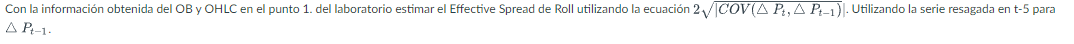

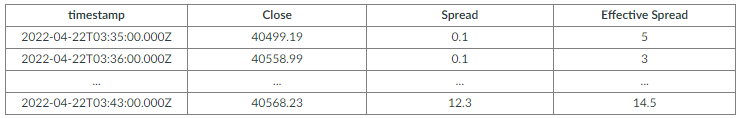

## 3.2 Verificacion de avance

In [48]:
closec1=c1m1[0]+c1m2[0]+c1m3[0]
closec2=c2m1[0]+c2m2[0]+c2m3[0]
closec3=c3m1[0]+c3m2[0]+c3m3[0]

date_closec1=c1m1[1]+c1m2[1]+c1m3[1]
date_closec1=c2m1[1]+c2m2[1]+c2m3[1]
date_closec1=c3m1[1]+c3m2[1]+c3m3[1]

In [49]:
def verifavance3(dates,closes):
    df=pd.DataFrame(columns=['timestamp','Close','Spread','Effective Spread'])
    df['timestamp']=dates
    df['Close']=closes
    #df['Spread']
#     for i in range(len(df)):
#         df.loc[i,'Effective Spread']=2*np.sqrt(np.abs(np.cov(np.diff(closes)[i+5],np.diff(closes)[i+5])))
    return df

In [50]:
verifavance3(date_closec1,closec1)

,timestamp,Close,Spread,Effective Spread
0,2022-11-09T23:21:00.000Z,15770.79,NaN,NaN
1,2022-11-09T23:22:00.000Z,15684.37,NaN,NaN
2,2022-11-09T23:23:00.000Z,15692.79,NaN,NaN
3,2022-11-09T23:24:00.000Z,15672.37,NaN,NaN
4,2022-11-09T23:25:00.000Z,15685.05,NaN,NaN
5,2022-11-09T23:26:00.000Z,15696.29,NaN,NaN
6,2022-11-09T23:27:00.000Z,15669.64,NaN,NaN
7,2022-11-09T23:28:00.000Z,15665.81,NaN,NaN
8,2022-11-09T23:29:00.000Z,15662.92,NaN,NaN
9,2022-11-09T23:30:00.000Z,15701.41,NaN,NaN


In [54]:
closes=closec1
delta=np.diff(closes)
np.cov(delta[0+5],delta[0])

<ipython-input-54-3e261c673336>:3: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\frida\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning:

divide by zero encountered in divide

C:\Users\frida\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning:

invalid value encountered in multiply



array([[nan, nan],
       [nan, nan]])

In [55]:
np.diff(closes)[5]

-26.650000000001455

In [56]:
np.diff(closes)[0]

-86.42000000000007